# QSudoku Demo: Basic Workflow

This notebook demonstrates the basic workflow of the quantum Sudoku solving framework, focusing on the `QSudoku` master class and `ExactCoverQuantumSolver`.

## Basic Workflow Steps:
1. **Puzzle Creation** - Generate or load a Sudoku puzzle
2. **Solver Setup** - Configure the quantum solving algorithm  
3. **Circuit Building** - Build the quantum circuit
4. **Backend Setup** - Configure simulator or real hardware
5. **Execution** - Run the quantum algorithm

In [15]:
# Import the main QSudoku class and ExactCoverQuantumSolver
from sudoku_nisq import QSudoku
from sudoku_nisq.exact_cover_solver import ExactCoverQuantumSolver

## Step 1: Puzzle Creation

Let's generate a simple 4x4 Sudoku puzzle with some missing cells.

Generated puzzle:
Size: 4x4
Missing cells: 2
Puzzle hash: 419adf0090ffc88d4293a60a37a16918a8ea2ae9137548d3d5f8b0cc029e38fe
Puzzle board: [[0, 4, 3, 1], [3, 1, 2, 4], [1, 3, 4, 2], [4, 2, 1, 0]]


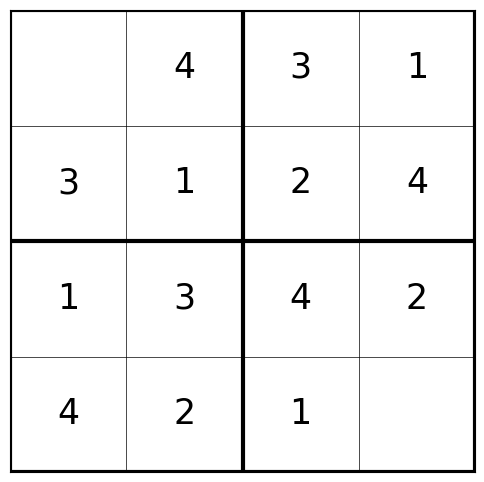

In [16]:
# Generate a 4x4 Sudoku puzzle with 6 missing cells
# subgrid_size=2 means 2x2 subgrids, creating a 4x4 puzzle
puzzle = QSudoku.generate(subgrid_size=2, num_missing_cells=2)

print(f"Generated puzzle:")
print(f"Size: {puzzle.board_size}x{puzzle.board_size}")
print(f"Missing cells: {puzzle.num_missing_cells}")
print(f"Puzzle hash: {puzzle.get_hash()}")
print(f"Puzzle board: {puzzle.board}")
puzzle.plot()

## Step 2: Solver Setup

Now we'll configure the quantum solving algorithm. We'll use the `ExactCoverQuantumSolver` with the "simple" encoding.

In [17]:
# Set the quantum solving algorithm
puzzle.set_solver(ExactCoverQuantumSolver, encoding="simple")

print("Solver configured:")
print(f"Solver class: {type(puzzle._solver).__name__}")
print(f"Encoding: {puzzle._solver.encoding}")
print(f"Active solver: {puzzle._solver is not None}")

Solver configured:
Solver class: ExactCoverQuantumSolver
Encoding: simple
Active solver: True


## Step 3: Circuit Building

Build the quantum circuit that implements the exact cover algorithm for our puzzle.

In [18]:
# Build the quantum circuit for the puzzle
circuit = puzzle.build_circuit()

print("Circuit built successfully!")

# Show basic circuit info
print(f"\nCircuit summary:")
print(f"Circuit qubits: {circuit.n_qubits}")
print(f"Circuit gates: {circuit.n_gates}")
print(f"Circuit depth: {circuit.depth()}")

Circuit built successfully!

Circuit summary:
Circuit qubits: 11
Circuit gates: 32
Circuit depth: 16


## Step 4: Backend Setup

We'll use the Aer simulator for this demo. For real hardware, you would need to configure IBM Quantum or other backend providers.

In [21]:
# Run on the Aer simulator
puzzle.run_aer(shots=1024)



BackendResult(q_bits={},c_bits={c[0]: 0, c[1]: 1},counts=None,shots=[[192]
 [192]
 [192]
 ...
 [192]
 [192]
 [192]],state=None,unitary=None,density_matrix=None)

## Summary

We've successfully demonstrated the basic QSudoku workflow:

1. ✅ **Generated** a 4x4 Sudoku puzzle
2. ✅ **Configured** the ExactCoverQuantumSolver
3. ✅ **Built** the quantum circuit
4. ✅ **Executed** on the Aer simulator

The framework automatically handles:
- Circuit caching and optimization
- Error handling and validation  
- Metadata collection and logging
- Memory management

Next, we can explore the `ExperimentRunner` for bulk experimentation!

# ExperimentRunner Demo: Bulk Experimentation

The `ExperimentRunner` enables systematic benchmarking across multiple parameters. Let's run a small batch experiment.

In [20]:
# Import the convenience function for batch experiments
from sudoku_nisq import run_experiment_batch

# Run a small batch experiment
# This will test ExactCoverQuantumSolver with 2 encodings 
# on 2 different puzzle difficulties, with 2 samples each
print("Starting small batch experiment...")

csv_path = run_experiment_batch(
    solvers_config={
        ExactCoverQuantumSolver: ["simple", "pattern"]  # 2 encodings
    },
    backends=["simulator"],  # Just simulator for demo
    puzzle_sizes=[2],        # 4x4 puzzles only  
    missing_cells=[3, 5],    # 2 difficulty levels
    samples_per_combo=2,     # 2 puzzle samples per combination
    csv_path="demo_experiment.csv",
    cache_base="./demo_cache"
)

print(f"\nExperiment completed! Results saved to: {csv_path}")

Starting small batch experiment...


ValueError: Backend 'simulator' not found in BackendManager. Available backends: []

In [ ]:
# Let's examine the results
import pandas as pd
import os

if os.path.exists("demo_experiment.csv"):
    df = pd.read_csv("demo_experiment.csv")
    
    print(f"Experiment generated {len(df)} CSV rows")
    print(f"Columns: {list(df.columns)}")
    
    print(f"\nBreakdown by solver and encoding:")
    breakdown = df.groupby(['solver_name', 'encoding']).size()
    print(breakdown)
    
    print(f"\nSample of circuit resources:")
    resource_cols = ['main_n_qubits', 'main_n_gates', 'main_depth']
    available_cols = [col for col in resource_cols if col in df.columns]
    if available_cols:
        print(df[['solver_name', 'encoding'] + available_cols].head())
    
    print(f"\nAny errors encountered:")
    if 'error' in df.columns:
        errors = df[df['error'].notna()]
        if len(errors) > 0:
            print(f"Found {len(errors)} errors")
            print(errors[['solver_name', 'encoding', 'error']].head())
        else:
            print("No errors found - all experiments succeeded!")
    
else:
    print("CSV file not found - experiment may not have completed")

## What Just Happened?

The `ExperimentRunner` systematically tested:

- **2 solver encodings** (simple, pattern)
- **2 puzzle difficulties** (3 and 5 missing cells)  
- **2 samples per combination** (for statistical reliability)
- **1 backend** (simulator)

This generated **8 total CSV rows**:
- 4 puzzles × 2 encodings × 1 main circuit row each = 8 rows

Each row contains:
- Puzzle metadata (size, missing cells, hash)
- Solver configuration (name, encoding) 
- Circuit resources (qubits, gates, depth)
- Any errors encountered

## Key Benefits

1. **Systematic**: Tests all parameter combinations
2. **Robust**: Continues even if individual experiments fail
3. **Comprehensive**: Logs everything to CSV for analysis
4. **Memory-safe**: Automatic cleanup prevents memory leaks
5. **Progress tracking**: Real-time updates during long runs

## Next Steps

For real research, you might run:
```python
run_experiment_batch(
    solvers_config={
        ExactCoverQuantumSolver: ["simple", "pattern", "optimized"],
        GraphColoringQuantumSolver: ["basic", "advanced"]
    },
    backends=["ibm_brisbane", "ibm_kyoto", "simulator"],
    puzzle_sizes=[2, 3],  # 4x4 and 9x9
    missing_cells=[3, 5, 7, 10],
    samples_per_combo=20,  # More statistical samples
    opt_levels=[0, 1, 2, 3]  # Test transpilation optimization
)
```

This would generate hundreds of data points for comprehensive analysis!